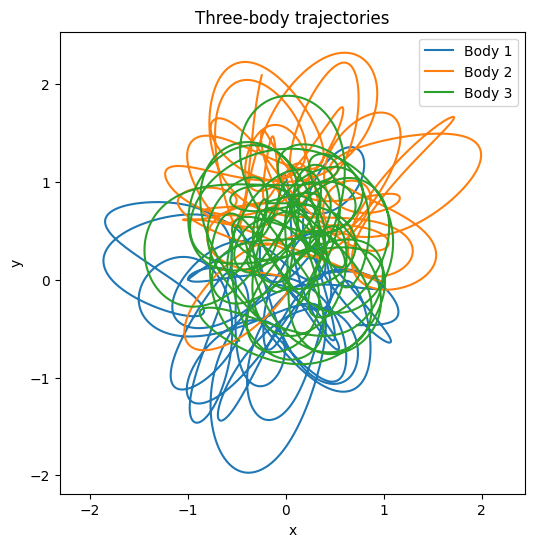

In [1]:
from data_creation import get_trajectories
%load_ext autoreload
%autoreload 2

sol = get_trajectories()

x,y,vx,vy,t = sol

# print((x1.shape), type(y1))

In [2]:
import numpy as np


# Applied sigmoid but does not seem to do much
# We can first try without sigmoid


# custom function
def sigmoid(x):
  return 1 / (1 + np.exp(-x))


# define vectorized sigmoid
sigmoid_v = np.vectorize(sigmoid)

# # test
x_sig = sigmoid(x)  
y_sig = sigmoid(y)
vx_sig = sigmoid(vx)
vy_sig = sigmoid(vy)


print(min(vx_sig[0]))
print(min(vy_sig[0]))



0.00023284527253112896
1.7000081657711662e-07


In [3]:
import numpy as np
import pandas as pd

data = np.vstack((x, y, vx, vy)).T

In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense

In [18]:


# prev = np.roll(data, shift=1, axis=0)  # previous row values
# prev[0] = np.nan   # first row has no previous row
# print(prev.shape)

# lagged = np.hstack([data, prev])

print(data.shape)

lag = 10  # number of lagged time steps to as labels
# # Create lagged features
X = data[:-lag]
y = data[lag:]





print(X.shape, y.shape)

# # Split the data into training and test sets
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]



scaler = MinMaxScaler(feature_range=(0, 1))

# Fit on training data and transform
X_train = scaler.fit_transform(X_train)

# Transform test data using the same scaler
X_test = scaler.transform(X_test)

seq_len = 10
X_train = np.array([X_train[i:i+seq_len] for i in range(len(X_train)-seq_len)])
X_test = np.array([X_test[i:i+seq_len] for i in range(len(X_test)-seq_len)])

print(X.shape, y.shape)
# # # Reshape the input data to 3D for LSTM
# X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
# X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))



(100000, 12)
(99990, 12) (99990, 12)
(99990, 12) (99990, 12)


In [6]:


# model = Sequential([
#     LSTM(10, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
#     Dense(12)
# ])

# model.compile(optimizer='adam', loss='mse')

# history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

# loss = model.evaluate(X_test, y_test)
# print(f'Test loss: {loss}')


# y_pred = model.predict(X_test)


In [7]:
# import matplotlib.pyplot as plt

# plt.plot(history.history['loss'], label='train loss')
# plt.plot(history.history['val_loss'], label='val loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Model training history')
# plt.legend()
# plt.show()


In [8]:
# from sklearn.metrics import r2_score, mean_absolute_error

# def smape(y_true, y_pred):
#     y_true, y_pred = np.array(y_true), np.array(y_pred)
#     denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
#     diff = np.abs(y_true - y_pred) / denominator
#     diff[denominator == 0] = 0.0  # avoid division by zero
#     return 100 * np.mean(diff)  

# mae = mean_absolute_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)


# score = smape(y_test, y_pred)
# print(f"SMAPE: {score:.2f}%")

# print(f"Test MAE: {mae:.4f}")
# print(f"Test R²: {r2:.4f}")

Fold 1
Epoch [1/20], Train Loss: 1.2453, Val Loss: 2.0968
Epoch [2/20], Train Loss: 1.2099, Val Loss: 2.1278
Epoch [3/20], Train Loss: 1.2064, Val Loss: 2.1336
Epoch [4/20], Train Loss: 1.1979, Val Loss: 2.1238
Epoch [5/20], Train Loss: 1.1879, Val Loss: 2.1157
Epoch [6/20], Train Loss: 1.1792, Val Loss: 2.1150
Epoch [7/20], Train Loss: 1.1697, Val Loss: 2.1040
Epoch [8/20], Train Loss: 1.1114, Val Loss: 2.1028
Epoch [9/20], Train Loss: 1.1160, Val Loss: 1.9501
Epoch [10/20], Train Loss: 1.0728, Val Loss: 1.8916
Epoch [11/20], Train Loss: 1.0537, Val Loss: 1.8724
Epoch [12/20], Train Loss: 1.0350, Val Loss: 1.8530
Epoch [13/20], Train Loss: 1.0109, Val Loss: 1.8290
Epoch [14/20], Train Loss: 0.9741, Val Loss: 1.8026
Epoch [15/20], Train Loss: 0.9220, Val Loss: 1.7835
Epoch [16/20], Train Loss: 0.8782, Val Loss: 1.7802
Epoch [17/20], Train Loss: 0.8178, Val Loss: 1.7876
Epoch [18/20], Train Loss: 0.7895, Val Loss: 1.7762
Epoch [19/20], Train Loss: 0.7830, Val Loss: 1.8019
Epoch [20/20],

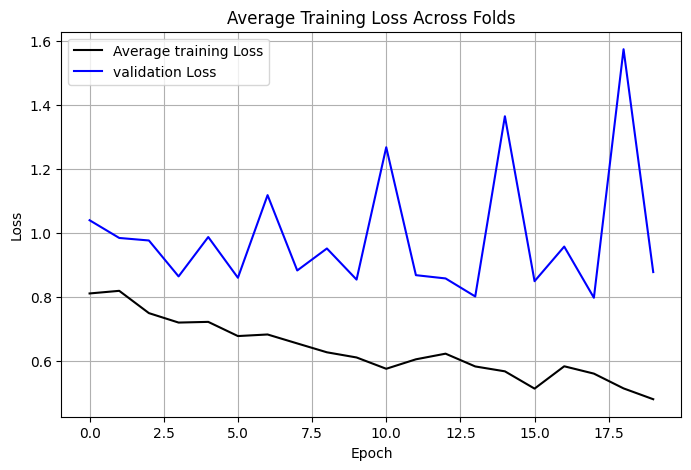

In [12]:
from LSTMCell import LSTM
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

class PowerLoss(nn.Module):
    def __init__(self, p=4):
        super().__init__()
        self.p = p

    def forward(self, y_pred, y_true):
        return torch.mean(torch.abs(y_pred - y_true) ** self.p)

input_window_size = 12
hidden_size = 128
num_layers = 2

model = LSTM(input_window_size, hidden_size, num_layers)

criterion = PowerLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

losses, val_loss = model.training_loop_cv(
    num_epochs = 20, 
    criterion = criterion,
    optimizer = optimizer,
    trainX = X_train,
    trainY = y_train
)

losses_array = np.array(losses)        # shape: (num_folds, num_epochs)
avg_loss = np.mean(losses_array, axis=0)

losses_array = np.array(val_loss)        # shape: (num_folds, num_epochs)
avg_val_loss = np.mean(losses_array, axis=0)

plt.figure(figsize=(8, 5))
plt.plot(avg_loss, color='black', label='Average training Loss')
plt.plot(avg_val_loss, color='blue', label='validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Average Training Loss Across Folds')
plt.grid(True)
plt.legend()
plt.show()

Generate time series from 1 input and plot both in one plot

In [32]:
from data_creation import plot_trajectories
steps = 200
print(X_train.shape, X_test[0].shape)
output = model.generate_timeseries(X_test[0], steps=steps//10)

plot_trajectories(X_test[0:steps], output)

(79982, 10, 12) (10, 12)
torch.Size([10, 12])


ValueError: not enough values to unpack (expected 3, got 2)

### Grid search

In [ ]:
from itertools import product

# define the grid search parameters
param_grid = {'neurons': [2, 4, 8, 16, 32, 64, 128],
              'optimizer': ['SGD', 'RMSprop', 'Adam']}


# generate combinations
keys = param_grid.keys()
combinations = [dict(zip(keys, values)) for values in product(*param_grid.values())]

for combo in combinations:
    print(combo)

{'neurons': 8, 'optimizer': 'SGD', 'activation': 'relu'}
{'neurons': 8, 'optimizer': 'SGD', 'activation': 'tanh'}
{'neurons': 8, 'optimizer': 'SGD', 'activation': 'sigmoid'}
{'neurons': 8, 'optimizer': 'SGD', 'activation': 'linear'}
{'neurons': 8, 'optimizer': 'SGD', 'activation': 'swish'}
{'neurons': 8, 'optimizer': 'RMSprop', 'activation': 'relu'}
{'neurons': 8, 'optimizer': 'RMSprop', 'activation': 'tanh'}
{'neurons': 8, 'optimizer': 'RMSprop', 'activation': 'sigmoid'}
{'neurons': 8, 'optimizer': 'RMSprop', 'activation': 'linear'}
{'neurons': 8, 'optimizer': 'RMSprop', 'activation': 'swish'}
{'neurons': 8, 'optimizer': 'Adam', 'activation': 'relu'}
{'neurons': 8, 'optimizer': 'Adam', 'activation': 'tanh'}
{'neurons': 8, 'optimizer': 'Adam', 'activation': 'sigmoid'}
{'neurons': 8, 'optimizer': 'Adam', 'activation': 'linear'}
{'neurons': 8, 'optimizer': 'Adam', 'activation': 'swish'}
{'neurons': 16, 'optimizer': 'SGD', 'activation': 'relu'}
{'neurons': 16, 'optimizer': 'SGD', 'activat